# Clustering on categorical data
- http://axon.cs.byu.edu/Dan/678/papers/Cluster/Xu.pdf
- https://scikit-learn.org/stable/unsupervised_learning.html

1. Using Gower’s similarity coefficient (Gower, 1971) and other dissimilarity measures (Gowda and Diday, 1991) the standard hierarchical clustering methods can handle data with numeric and categorical values (Anderberg, 1973; Jain and Dubes, 1988). However, the quadratic computational cost makes them unacceptable for clustering large data sets.

2. Conceptual clustering algorithms - Conceptual clustering algorithms developed in machine learning cluster data with categorical values (Michalski and Stepp, 1983; Fisher, 1987; Lebowitz, 1987) and also produce conceptual descriptions of clusters. The latter feature is important to data mining because the conceptual descriptions provide assistance in interpreting clustering results. Unlike statistical clustering methods, these algorithms are based on a search for objects which carry the same or similar concepts. Therefore, their efficiency relies on good search strategies. . Some popular ones include CLARANS (Ng and Han, 1994), DBSCAN (Ester et al., 1996) and BIRCH (Zhang et al., 1996). These algorithms are often revisions of some existing clustering methods. Again, these algorithms still target on numeric data and cannot be used to solve massive categorical data clustering problems.

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data', header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [0]:
kmeans - 277
heirarchical - 117
rock - 117
sbac - 183
artmap - 56
autoclass - 183



In [0]:
import numpy as np
from kmodes.kmodes import KModes

# reproduce results on small soybean data set
x = np.genfromtxt('https://raw.githubusercontent.com/nicodv/kmodes/master/examples/soybean.csv', dtype=int, delimiter=',')[:, :-1]
y = np.genfromtxt('https://raw.githubusercontent.com/nicodv/kmodes/master/examples/soybean.csv', dtype=str, delimiter=',', usecols=(35, ))

kmodes_huang = KModes(n_clusters=4, init='Huang', verbose=1)
kmodes_huang.fit(x)

# Print cluster centroids of the trained model.
print('k-modes (Huang) centroids:')
print(kmodes_huang.cluster_centroids_)
# Print training statistics
print('Final training cost: {}'.format(kmodes_huang.cost_))
print('Training iterations: {}'.format(kmodes_huang.n_iter_))

kmodes_cao = KModes(n_clusters=4, init='Cao', verbose=1)
kmodes_cao.fit(x)

# Print cluster centroids of the trained model.
print('k-modes (Cao) centroids:')
print(kmodes_cao.cluster_centroids_)
# Print training statistics
print('Final training cost: {}'.format(kmodes_cao.cost_))
print('Training iterations: {}'.format(kmodes_cao.n_iter_))

print('Results tables:')
for result in (kmodes_huang, kmodes_cao):
    classtable = np.zeros((4, 4), dtype=int)
    for ii, _ in enumerate(y):
        classtable[int(y[ii][-1]) - 1, result.labels_[ii]] += 1

    print("\n")
    print("    | Cl. 1 | Cl. 2 | Cl. 3 | Cl. 4 |")
    print("----|-------|-------|-------|-------|")
    for ii in range(4):
        prargs = tuple([ii + 1] + list(classtable[ii, :]))
        print(" D{0} |    {1:>2} |    {2:>2} |    {3:>2} |    {4:>2} |".format(*prargs))

## MCA
- https://nbviewer.jupyter.org/github/esafak/mca/blob/master/docs/mca-BurgundiesExample.ipynb
- https://github.com/esafak/mca/blob/master/docs/usage.rst

In [0]:
from functools import reduce

from numpy import apply_along_axis, argmax, array, cumsum, diag, dot, finfo, flatnonzero, int64, outer, sqrt
from numpy.linalg import norm, svd
from pandas import concat, get_dummies
from scipy.linalg import diagsvd
from scipy.sparse import diags
from scipy.sparse.linalg import svds

def process_df(DF, cols, ncols):
	if cols:  # if you want us to do the dummy coding
		K = len(cols)  # the number of categories
		X = dummy(DF, cols)
	else:  # if you want to dummy code it yourself or do all the cols
		K = ncols
		if ncols is None:  # be sure to pass K if you didn't multi-index
			K = len(DF.columns)  # ... it with mca.dummy()
			if not K:
				raise ValueError("Your DataFrame has no columns.")
		elif not isinstance(ncols, int) or ncols <= 0 or \
					ncols > len(DF.columns):  # if you dummy coded it yourself
			raise ValueError("You must pass a valid number of columns.")
		X = DF
	J = X.shape[1]
	return X, K, J


def dummy(DF, cols=None):
	"""Dummy code select columns of a DataFrame."""
	dummies = (get_dummies(DF[col]) for col in 
		(DF.columns if cols is None else cols))
	return concat(dummies, axis=1, keys=DF.columns)


def _mul(*args):
	"""An internal method to multiply matrices."""
	return reduce(dot, args)


class MCA(object):
	"""Run MCA on selected columns of a pd DataFrame.
	
	If the column are specified, assume that they hold
	categorical variables that need to be replaced with
	dummy indicators, otherwise process the DataFrame as is.
	'cols': The columns of the DataFrame to process.
	'ncols': The number of columns before dummy coding. To be passed if cols isn't.
	'benzecri': Perform Benzécri correction (default: True)
	'TOL': value below which to round eigenvalues to zero (default: 1e-4)
	"""

	def __init__(self, DF, cols=None, ncols=None, benzecri=True, TOL=1e-4, 
		sparse=False, approximate=False):

		X, self.K, self.J = process_df(DF, cols, ncols)
		S = X.sum().sum()
		Z = X / S  # correspondence matrix
		self.r = Z.sum(axis=1)
		self.c = Z.sum()
		self.cor = benzecri

		eps = finfo(float).eps
		self.D_r = (diags if sparse else diag)(1/(eps + sqrt(self.r)))
		self.D_c = diag(1/(eps + sqrt(self.c)))  # can't use diags here
		Z_c = Z - outer(self.r, self.c)  # standardized residuals matrix

		product = self.D_r.dot(Z_c).dot(self.D_c)
		if sparse:
			P, s, Q = svds(product, min(product.shape)-1 if ncols is None else ncols)
			# svds and svd use complementary orders
			self.P = P.T[::-1].T
			self.Q = Q[::-1]
			self.s = s[::-1]
			self._numitems = min(product.shape)-1
		else:
			self._numitems = len(DF)
			self.P, self.s, self.Q = svd(product)

		self.E = None
		E = self._benzecri() if self.cor else self.s**2
		self.inertia = sum(E)
		self.rank = argmax(E < TOL)
		if not self.rank: self.rank = len(E)
		self.L = E[:self.rank]

	def _benzecri(self):
		if self.E is None:
			self.E = array([(self.K/(self.K-1.)*(_ - 1./self.K))**2
							  if _ > 1./self.K else 0 for _ in self.s**2])
		return self.E

	def fs_r(self, percent=0.9, N=None):
		"""Get the row factor scores (dimensionality-reduced representation),
		choosing how many factors to retain, directly or based on the explained
		variance.
		'percent': The minimum variance that the retained factors are required
								to explain (default: 90% = 0.9)
		'N': The number of factors to retain. Overrides 'percent'.
				If the rank is less than N, N is ignored.
		"""
		if not 0 <= percent <= 1:
			raise ValueError("Percent should be a real number between 0 and 1.")
		if N:
			if not isinstance(N, (int, int64)) or N <= 0:
				raise ValueError("N should be a positive integer.")
			N = min(N, self.rank)
		self.k = 1 + flatnonzero(cumsum(self.L) >= sum(self.L)*percent)[0]
		#  S = zeros((self._numitems, self.k))
		# the sign of the square root can be either way; singular value vs. eigenvalue
		# fill_diagonal(S, -sqrt(self.E) if self.cor else self.s)
		num2ret = N if N else self.k
		s = -sqrt(self.L) if self.cor else self.s
		S = diagsvd(s[:num2ret], self._numitems, num2ret)
		self.F = self.D_r.dot(self.P).dot(S)
		return self.F

	def fs_c(self, percent=0.9, N=None):
		"""Get the column factor scores (dimensionality-reduced representation),
		choosing how many factors to retain, directly or based on the explained
		variance.
		'percent': The minimum variance that the retained factors are required
								to explain (default: 90% = 0.9)
		'N': The number of factors to retain. Overrides 'percent'.
				If the rank is less than N, N is ignored.
		"""
		if not 0 <= percent <= 1:
			raise ValueError("Percent should be a real number between 0 and 1.")
		if N:
			if not isinstance(N, (int, int64)) or N <= 0:
				raise ValueError("N should be a positive integer.")
			N = min(N, self.rank)  # maybe we should notify the user?
			# S = zeros((self._numitems, N))
		# else:
		self.k = 1 + flatnonzero(cumsum(self.L) >= sum(self.L)*percent)[0]
		#  S = zeros((self._numitems, self.k))
		# the sign of the square root can be either way; singular value vs. eigenvalue
		# fill_diagonal(S, -sqrt(self.E) if self.cor else self.s)
		num2ret = N if N else self.k
		s = -sqrt(self.L) if self.cor else self.s
		S = diagsvd(s[:num2ret], len(self.Q), num2ret)
		self.G = _mul(self.D_c, self.Q.T, S)  # important! note the transpose on Q
		return self.G

	def cos_r(self, N=None):  # percent=0.9
		"""Return the squared cosines for each row."""

		if not hasattr(self, 'F') or self.F.shape[1] < self.rank:
			self.fs_r(N=self.rank)  # generate F
		self.dr = norm(self.F, axis=1)**2
		# cheaper than diag(self.F.dot(self.F.T))?

		return apply_along_axis(lambda _: _/self.dr, 0, self.F[:, :N]**2)

	def cos_c(self, N=None):  # percent=0.9,
		"""Return the squared cosines for each column."""

		if not hasattr(self, 'G') or self.G.shape[1] < self.rank:
			self.fs_c(N=self.rank)  # generate
		self.dc = norm(self.G, axis=1)**2
		# cheaper than diag(self.G.dot(self.G.T))?

		return apply_along_axis(lambda _: _/self.dc, 0, self.G[:, :N]**2)

	def cont_r(self, percent=0.9, N=None):
		"""Return the contribution of each row."""

		if not hasattr(self, 'F'):
			self.fs_r(N=self.rank)  # generate F
		return apply_along_axis(lambda _: _/self.L[:N], 1,
			   apply_along_axis(lambda _: _*self.r, 0, self.F[:, :N]**2))

	def cont_c(self, percent=0.9, N=None):  # bug? check axis number 0 vs 1 here
		"""Return the contribution of each column."""

		if not hasattr(self, 'G'):
			self.fs_c(N=self.rank)  # generate G
		return apply_along_axis(lambda _: _/self.L[:N], 1,
			   apply_along_axis(lambda _: _*self.c, 0, self.G[:, :N]**2))

	def expl_var(self, greenacre=True, N=None):
		"""
		Return proportion of explained inertia (variance) for each factor.
		:param greenacre: Perform Greenacre correction (default: True)
		"""
		if greenacre:
			greenacre_inertia = (self.K / (self.K - 1.) * (sum(self.s**4)
								 - (self.J - self.K) / self.K**2.))
			return (self._benzecri() / greenacre_inertia)[:N]
		else:
			E = self._benzecri() if self.cor else self.s**2
			return (E / sum(E))[:N]

	def fs_r_sup(self, DF, N=None):
		"""Find the supplementary row factor scores.
		ncols: The number of singular vectors to retain.
		If both are passed, cols is given preference.
		"""
		if not hasattr(self, 'G'):
			self.fs_c(N=self.rank)  # generate G

		if N and (not isinstance(N, int) or N <= 0):
			raise ValueError("ncols should be a positive integer.")
		s = -sqrt(self.E) if self.cor else self.s
		N = min(N, self.rank) if N else self.rank
		S_inv = diagsvd(-1/s[:N], len(self.G.T), N)
		# S = diagsvd(s[:N], len(self.tau), N)
		return _mul(DF.div(DF.sum(axis=1), axis=0), self.G, S_inv)[:, :N]

	def fs_c_sup(self, DF, N=None):
		"""Find the supplementary column factor scores.
		ncols: The number of singular vectors to retain.
		If both are passed, cols is given preference.
		"""
		if not hasattr(self, 'F'):
			self.fs_r(N=self.rank)  # generate F

		if N and (not isinstance(N, int) or N <= 0):
			raise ValueError("ncols should be a positive integer.")
		s = -sqrt(self.E) if self.cor else self.s
		N = min(N, self.rank) if N else self.rank
		S_inv = diagsvd(-1/s[:N], len(self.F.T), N)
		# S = diagsvd(s[:N], len(self.tau), N)
		return _mul((DF/DF.sum()).T, self.F, S_inv)[:, :N]

In [39]:
data = pd.read_csv('https://raw.githubusercontent.com/nicodv/kmodes/master/examples/soybean.csv', header=None)
data = data.iloc[:, :-1]
data.head()

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,4,0,2,1,1,1,0,1,0,2,...,0,0,0,4,0,0,0,0,0,0
1,5,0,2,1,0,3,1,1,1,2,...,0,0,0,4,0,0,0,0,0,0
2,3,0,2,1,0,2,0,2,1,1,...,0,0,0,4,0,0,0,0,0,0
3,6,0,2,1,0,1,1,1,0,0,...,0,0,0,4,0,0,0,0,0,0
4,4,0,2,1,0,3,0,2,0,2,...,0,0,0,4,0,0,0,0,0,0


In [0]:
X = data.copy()
mca_ben = MCA(X, cols=data.columns.tolist())
mca_ind = MCA(X, cols=data.columns.tolist(), benzecri=False)

df = {'Iλ': pd.Series(mca_ind.L),
        'τI': pd.Series(mca_ind.expl_var(greenacre=False, N=4)),
        'Zλ': pd.Series(mca_ben.L),
        'τZ': pd.Series(mca_ben.expl_var(greenacre=False, N=4)),
        'cλ': pd.Series(mca_ben.L),
        'τc': pd.Series(mca_ind.expl_var(greenacre=True, N=4))}

# 'Indicator Matrix', 'Benzecri Correction', 'Greenacre Correction'
columns = ['Iλ', 'τI', 'Zλ', 'τZ', 'cλ', 'τc']
table2 = pd.DataFrame(data=df, columns=columns).fillna(0)
table2.index += 1
table2.loc['Σ'] = table2.sum()
table2.index.name = 'Factor'

table2

In [54]:
print(MCA(data).fs_r(1)) # 1 = 100%, meaning preserve all variance

[[ 0.0051741   0.14460348  0.00242016]
 [ 0.01576698  0.15694987 -0.00062607]
 [-0.03844862  0.15567997  0.01392275]
 [ 0.05387422  0.16291003  0.00394802]
 [-0.01552629  0.14539909  0.00625295]
 [ 0.02337566  0.16550611  0.00850046]
 [-0.0058762   0.15893417  0.00080356]
 [-0.04147088  0.15733976  0.01098325]
 [ 0.02057804  0.15655187  0.01125979]
 [ 0.02227734  0.16683203  0.00607932]
 [ 0.34600129 -0.02952941 -0.00710857]
 [ 0.27731017 -0.06045476  0.00329534]
 [ 0.27616938 -0.03111748 -0.00120585]
 [ 0.29381063 -0.04572157 -0.00044241]
 [ 0.31734464 -0.0760863  -0.00035892]
 [ 0.29276194 -0.05486684 -0.0089779 ]
 [ 0.30875991 -0.07738959  0.00564723]
 [ 0.29071925 -0.02675723 -0.01259886]
 [ 0.32059346 -0.04242064  0.00819965]
 [ 0.27253912 -0.04406353 -0.00292276]
 [-0.19499647 -0.04916141 -0.04602307]
 [-0.12587897 -0.01676313 -0.00907215]
 [-0.14583721 -0.01792408 -0.05051375]
 [-0.18012526 -0.04529398 -0.00641222]
 [-0.17118065 -0.04333482 -0.00345135]
 [-0.05580843  0.01947236

In [0]:
>>> from sklearn.metrics.cluster import contingency_matrix
>>> x = ["a", "a", "a", "b", "b", "b"]
>>> y = [0, 0, 1, 1, 2, 2]
>>> contingency_matrix(x, y)
array([[2, 1, 0],
       [0, 1, 2]])

**Target/WoE Encode -> PCA 2D -> Clustering algorithms -> Evaluation**

# ROCK Clustering

In [66]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,4,0,2,1,1,1,0,1,0,2,...,0,0,0,4,0,0,0,0,0,0
1,5,0,2,1,0,3,1,1,1,2,...,0,0,0,4,0,0,0,0,0,0
2,3,0,2,1,0,2,0,2,1,1,...,0,0,0,4,0,0,0,0,0,0
3,6,0,2,1,0,1,1,1,0,0,...,0,0,0,4,0,0,0,0,0,0
4,4,0,2,1,0,3,0,2,0,2,...,0,0,0,4,0,0,0,0,0,0


In [74]:
!pip install pyclustering

    100% |████████████████████████████████| 2.1MB 12.6MB/s 
  Stored in directory: /root/.cache/pip/wheels/d6/61/75/0f70c5f9e363b194b6bc197794c4376f72a550e9d5faf19958
Successfully built pyclustering


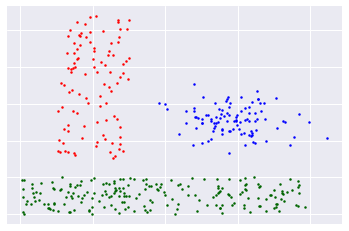

In [78]:
from pyclustering.cluster import cluster_visualizer;
from pyclustering.cluster.cure import cure;
from pyclustering.utils import read_sample;
from pyclustering.samples.definitions import FCPS_SAMPLES;

# Input data in following format [ [0.1, 0.5], [0.3, 0.1], ... ].
input_data = read_sample(FCPS_SAMPLES.SAMPLE_LSUN);

# Allocate three clusters.
cure_instance = cure(input_data, 3);
cure_instance.process();
clusters = cure_instance.get_clusters();

# Visualize allocated clusters.
visualizer = cluster_visualizer();
visualizer.append_clusters(clusters, input_data);
visualizer.show();

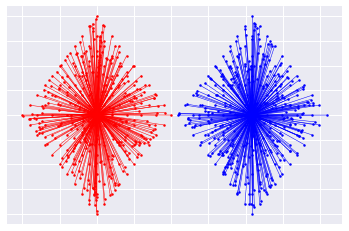

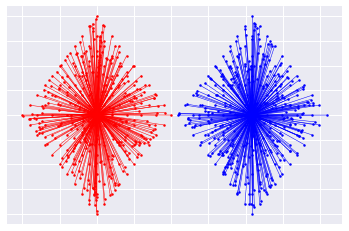

In [79]:
from pyclustering.cluster.kmeans import kmeans, kmeans_visualizer
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.samples.definitions import FCPS_SAMPLES
from pyclustering.utils import read_sample

# Load list of points for cluster analysis.
sample = read_sample(FCPS_SAMPLES.SAMPLE_TWO_DIAMONDS)

# Prepare initial centers using K-Means++ method.
initial_centers = kmeans_plusplus_initializer(sample, 2).initialize()

# Create instance of K-Means algorithm with prepared centers.
kmeans_instance = kmeans(sample, initial_centers)

# Run cluster analysis and obtain results.
kmeans_instance.process()
clusters = kmeans_instance.get_clusters()
final_centers = kmeans_instance.get_centers()

# Visualize obtained results
kmeans_visualizer.show_clusters(sample, clusters, final_centers)

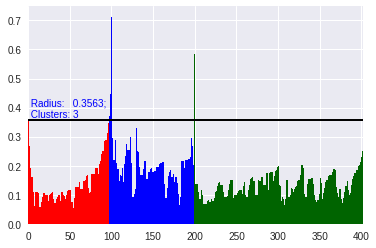

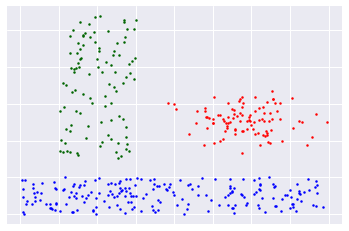

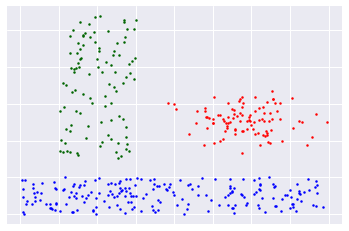

In [80]:
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.optics import optics, ordering_analyser, ordering_visualizer
from pyclustering.samples.definitions import FCPS_SAMPLES
from pyclustering.utils import read_sample

# Read sample for clustering from some file
sample = read_sample(FCPS_SAMPLES.SAMPLE_LSUN)

# Run cluster analysis where connectivity radius is bigger than real
radius = 2.0
neighbors = 3
amount_of_clusters = 3
optics_instance = optics(sample, radius, neighbors, amount_of_clusters)

# Performs cluster analysis
optics_instance.process()

# Obtain results of clustering
clusters = optics_instance.get_clusters()
noise = optics_instance.get_noise()
ordering = optics_instance.get_ordering()

# Visualize ordering diagram
analyser = ordering_analyser(ordering)
ordering_visualizer.show_ordering_diagram(analyser, amount_of_clusters)

# Visualize clustering results
visualizer = cluster_visualizer()
visualizer.append_clusters(clusters, sample)
visualizer.show()

In [83]:
data.values

array([[4, 0, 2, ..., 0, 0, 0],
       [5, 0, 2, ..., 0, 0, 0],
       [3, 0, 2, ..., 0, 0, 0],
       ...,
       [2, 1, 1, ..., 0, 0, 1],
       [0, 1, 1, ..., 0, 0, 1],
       [0, 1, 2, ..., 0, 0, 1]])

In [86]:
# Create instance of ROCK algorithm for cluster analysis
from pyclustering.cluster.rock import rock

# Five clusters should be allocated
rock_instance = rock(data.values, 1.0, 5, threshold = 0.5)

# Run cluster analysis
rock_instance.process();

# Obtain results of clustering
clusters = rock_instance.get_clusters(); 
clusters.index

# Visualize clustering results
# from pyclustering.cluster import cluster_visualizer
# visualizer = cluster_visualizer()
# visualizer.append_clusters(clusters, data.values)
# visualizer.show()

<function list.index>

In [82]:
rock.

[[0],
 [1],
 [2],
 [3],
 [4],
 [5],
 [6],
 [7],
 [8],
 [9],
 [10],
 [11],
 [12],
 [13],
 [14],
 [15],
 [16],
 [17],
 [18],
 [19],
 [20],
 [21],
 [22],
 [23],
 [24],
 [25],
 [26],
 [27],
 [28],
 [29],
 [30],
 [31],
 [32],
 [33],
 [34],
 [35],
 [36],
 [37],
 [38],
 [39],
 [40],
 [41],
 [42],
 [43],
 [44],
 [45],
 [46]]